In [1]:
using DelimitedFiles, HDF5, FileIO
using Plots, Rsvg, LaTeXStrings
using Chemfiles, JUMD, NamedArrays
using LinearAlgebra, Statistics
home = "/home/pbarletta/labo/20/dynein/run"
rtdos = "/home/pbarletta/labo/20/dynein/rtdos_log"

"/home/pbarletta/labo/20/dynein/rtdos_log"

### Lee modos, volumen original y  volúmenes NDD. Obtiene VGV

In [2]:
pdb = "1xdx"
# Leo modos
modes_f95, evals_f95 = JUMD.readPtrajModes(joinpath(home, pdb,  "3_pca", string("3_modes_", pdb)))

# AAs
aa3 = convert(Int64, length(evals_f95))
aa = convert(Int64, aa3 / 3)

# Leo volumen de la traj
trj_vol_acb = convert(Array{Float64, 1},
    readdlm(joinpath(home, pdb, "3_cavidad", "3_vol_acb_trj_het"))[:, 3]);
trj_vol_adb = convert(Array{Float64, 1},
    readdlm(joinpath(home, pdb, "3_cavidad", "3_vol_adb_trj_het"))[:, 3]);

# Leo volúmenes originales
vol_avg_acb = convert(Float64, readdlm(joinpath(home, pdb,  "3_cavidad", "3_vol_acb_het"))[2])
vol_avg_adb = convert(Float64, readdlm(joinpath(home, pdb,  "3_cavidad", "3_vol_adb_het"))[2])

246.31

## Volumen de la trayectoria

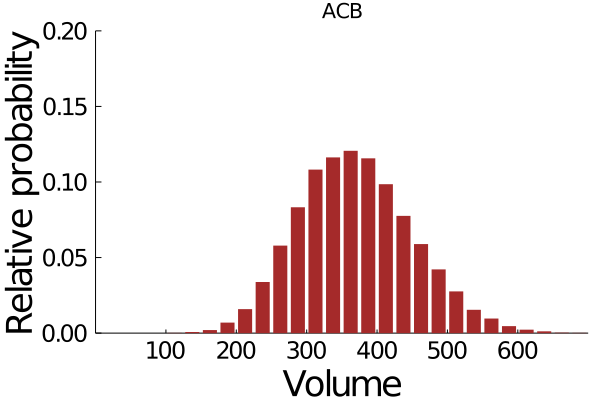

In [10]:
st = 25
min_vol = 100
max_vol = 700
bin_vol = collect(min_vol:st:max_vol)
wgh_vol = fill(1.0, length(trj_vol_acb))

# Histograma ponderado
Wbins_vol_acb, Whis_vol_acb = JUMD.weightedHist(trj_vol_acb, bin_vol, wgh_vol, true, false);

plt_his_vol = bar(Wbins_vol_acb, Whis_vol_acb,
    xlims = (0, max_vol), ylims = (0, .2),
    xticks = 100:100:max_vol-50,
    linecolor = false, fillcolor = Colors.colorant"Brown",
    grid = false, legend = false,
    guidefont = font(24, "Arial"), tickfont = font(16, "Arial"),
    legendfont = font(16, "Arial"),
    title = "ACB", yaxis = "Relative probability", xaxis = "Volume")

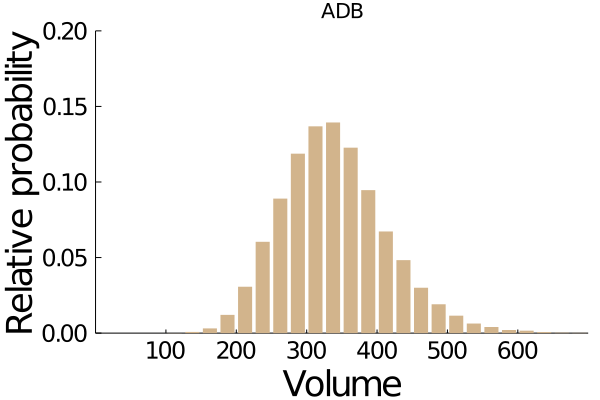

In [11]:
# Histograma ponderado
Wbins_vol_adb, Whis_vol_adb = JUMD.weightedHist(trj_vol_adb, bin_vol, wgh_vol, true, false);

plt_his_vol = bar(Wbins_vol_adb, Whis_vol_adb,
    xlims = (0, max_vol), ylims = (0, .2),
    xticks = 100:100:max_vol-50,
    linecolor = false, fillcolor = Colors.colorant"Tan",
    grid = false, legend = false,
    guidefont = font(24, "Arial"), tickfont = font(16, "Arial"),
    legendfont = font(16, "Arial"),
    title = "ADB", yaxis = "Relative probability", xaxis = "Volume")

In [12]:
NamedArray([ mean(trj_vol_acb) std(trj_vol_acb) std(trj_vol_acb) / mean(trj_vol_acb) ; 
     mean(trj_vol_adb) std(trj_vol_adb) std(trj_vol_adb) / mean(trj_vol_adb) ],
    (["ACB" ; "ADB"], ["μ" ; "std" ; "μ/std"]))

2×3 Named Array{Float64,2}
A ╲ B │        μ       std     μ/std
──────┼─────────────────────────────
ACB   │  369.361   80.7054    0.2185
ADB   │  338.908   74.6672  0.220317

# PCA projección
#### Obtengo vectores diferencia de la trayectoria. Esto lo hago una sola vez

#### Obtengo las proyecciónes de vectores diferencia sobre los 1eros PCA

In [7]:
dif = h5read(joinpath(rtdos, string("3_diff_", pdb, ".h5")), "dif")
norm_dif = mapslices(x -> x ./ norm(x), dif, dims = 1)
nframes = size(dif)[2]

prj_1_f95 = Array{Float64, 1}(undef, nframes)
prj_2_f95 = Array{Float64, 1}(undef, nframes)
prj_3_f95 = Array{Float64, 1}(undef, nframes)

for i = 1:nframes
    prj_1_f95[i] = dot(norm_dif[:, i], modes_f95[:, 1])
    prj_2_f95[i] = dot(norm_dif[:, i], modes_f95[:, 2])
    prj_3_f95[i] = dot(norm_dif[:, i], modes_f95[:, 3])
end

# Smooth
smooth_prj_1_f95 = [ mean(prj_1_f95[i:i+9]) for i = 1:10:length(prj_1_f95)-9 ]
smooth_prj_2_f95 = [ mean(prj_2_f95[i:i+9]) for i = 1:10:length(prj_2_f95)-9 ]
smooth_prj_3_f95 = [ mean(prj_3_f95[i:i+9]) for i = 1:10:length(prj_3_f95)-9 ];

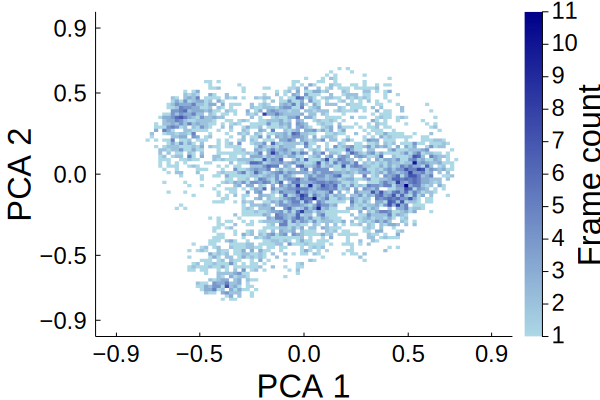

In [8]:
plt_2his = histogram2d(smooth_prj_1_f95, smooth_prj_2_f95, 
    xlims = (-1, 1), ylims = (-1, 1),
    xticks = [-.9 ; -.5 ; 0. ;.5 ; .9], yticks = [-.9 ; -.5 ; 0. ;.5 ; .9],
    yaxis = "PCA 2", xaxis = "PCA 1",
    colorbar_title = "Frame count",
    guidefont = font(22, "Arial"), tickfont = font(16, "Arial"),
    legendfont = font(16, "Arial"), #clims = (0, 15),
    nbins = 120, seriescolor = :blues, grid = false)

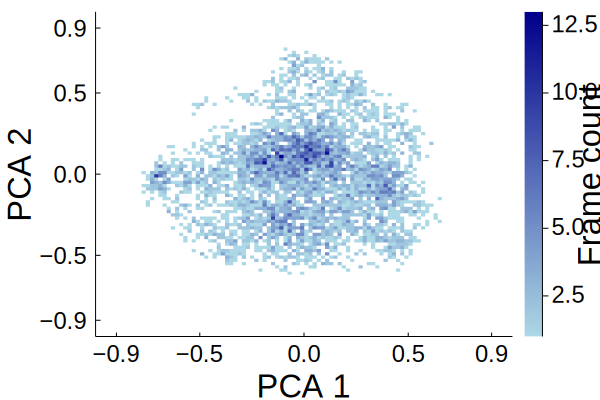

In [9]:
plt_2his = histogram2d(smooth_prj_2_f95, smooth_prj_3_f95, 
    xlims = (-1, 1), ylims = (-1, 1),
    xticks = [-.9 ; -.5 ; 0. ;.5 ; .9], yticks = [-.9 ; -.5 ; 0. ;.5 ; .9],
    yaxis = "PCA 2", xaxis = "PCA 1",
    colorbar_title = "Frame count",
    guidefont = font(22, "Arial"), tickfont = font(16, "Arial"),
    legendfont = font(16, "Arial"), #clims = (0, 15),
    nbins = 120, seriescolor = :blues, grid = false)